<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 2 - Redes Convolucionales y sus aplicaciones </H3>
<hr style="height:2px;border:none"/>

### Pregunta 1. Convolutional Neural Networks (CNN) en *CIFAR*

Integrantes:

- Christian Da Rocha, ROL: 2018.90.251-9
- Rodrigo Hermosilla, ROL: 95.74.144-4


##### Carga inicial de librerias
> En la siguiente sección y de manera previa se cargan todas las librerías necesarias para el ejercicio. Para efectos de mantener cierto orden con el código de las preguntas del ejercicio, se determino que todas las cargas se realizaran previamente, no obstante, se entiende que esto podría generar alguna ineficiencia en el consumo de recursos, pero que suponemos es marginal.

In [2]:
import numpy as np   
import os   
import tensorflow as tf
from scipy import stats
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sn
import pandas as pd
import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import LearningRateScheduler
import math
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix
import cv2
from keras.datasets import cifar10
from keras import backend as K

Using TensorFlow backend.


> Descarga y asignación de variables estructuras globales

In [3]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  

##### Pregunta A.

<div class="alert alert-block alert-success">
    <b>Nota: </b>Para efectos de mejorar la modularización, el ejercicio construye una serie de funciones, permitiendo además su reutilización en distintos instantes.
</div>

> Función que carga todos los bloques de datos en las respectivas matrices. Notese que las matrices de validación utilizan el *10%* de los datos de entrenamiento. Finalmente se cargan los datos.

In [4]:
def getData():
    global xtr, ytr, xt, yt, xval, yval, X_train, X_val, y_train, y_val, X_test, y_test
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    xtr = X_train.transpose([0, 3, 1, 2])
    xt= X_test.transpose([0, 3, 1, 2])
    xval= X_val.transpose([0, 3, 1, 2])
    ytr = keras.utils.to_categorical(y_train, len(label_names))
    yt = keras.utils.to_categorical(y_test, len(label_names))
    yval = keras.utils.to_categorical(y_val, len(label_names))
    
    

In [5]:
getData()

> A continuación es posible visualizar muestras (las primeras 10, y la primera ampliada respectivamente), desde la matriz de entrenamiento original.

In [6]:
def drawImg(X_train, y_train, i):
    im = X_train[i]
    c = y_train[i]
    plt.imshow(im)
    print(y_train[i])
    plt.title("Clase "+str(y_train[i])+" ("+label_names[int(y_train[i])]+")")
    plt.axis('on')
    plt.show()

def drawSample(X, y, n, rows=4, cols=4, fontsize=12):
    fig = plt.figure(figsize=(16,6))
    for i in range(0, rows*cols):
        fig.add_subplot(rows,cols,i+1)
        im = X[n+i].reshape(32,32,3)
        plt.imshow(im)
        plt.title("Clase "+str(y_train[i])+" ("+label_names[int(y_train[i])]+")")
        plt.axis('off')
        plt.subplots_adjust(hspace=0.45, wspace=0.45)
    plt.show()


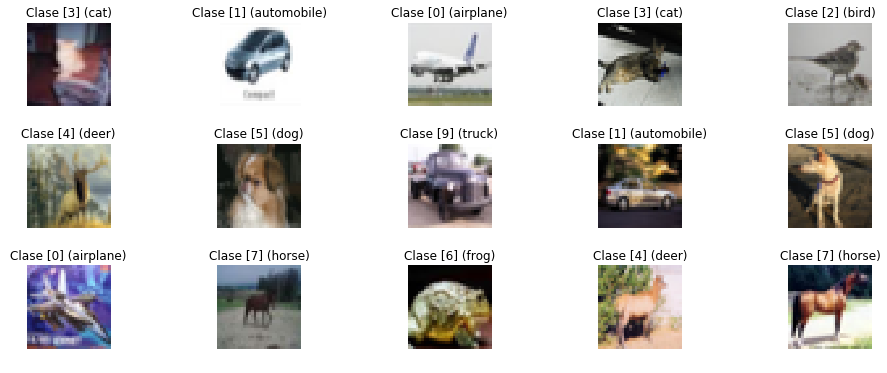

[3]


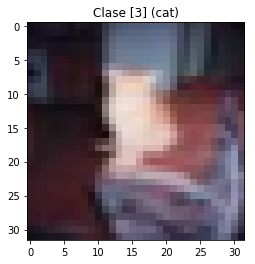

In [9]:
drawSample(X_train, y_train, 0, 3, 5)
drawImg(X_train, y_train, 0)

##### Pregunta B.

> En la siguiente etapa del proceso, se normalizaron los canales de las distintas matrices (división por 255). 

In [7]:
def normalize():
    global xtr, xval, xt
    xtr = xtr.astype('float32')
    xt = xt.astype('float32')
    xval = xval.astype('float32')
    xtr /= 255
    xt /=  255
    xval /= 255


In [11]:
normalize()

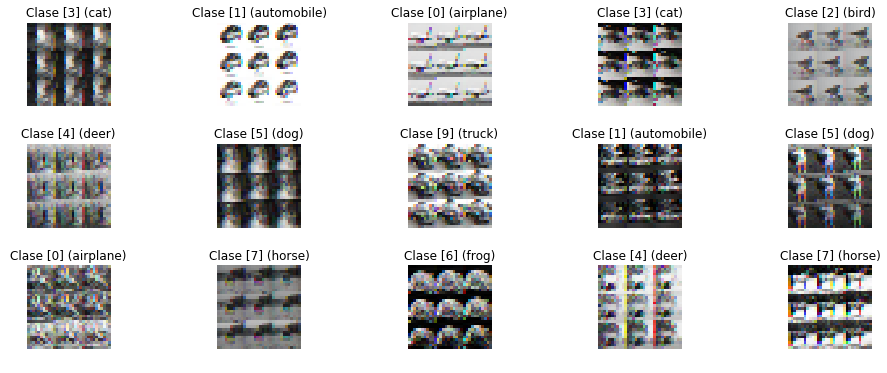

In [12]:
drawSample(xtr, ytr, 0, 3, 5)

> En las imagenes anteriores es visible el efecto de la normalización.

##### Pregunta C.

<div class="alert alert-block alert-success">
Para efectos de simplificar la comprensión del desarrollo, los modelos han sido generado a través de funciones, las cuales has sido identificadas por el sufijo <b>M</b>, donde <i>M</i> corresponde a la letra de la pregunta respectiva, por ejemplo, en la pregunta c, la función de generación de modelo es denominada <b>modelC</b>.
</div>

> A continuación se define una red CxPxCxPxFxF.

In [13]:
def modelC():
    model = Sequential()
    #C
    model.add(
        Conv2D(
            16, (4, 4),
            padding='valid',
            input_shape=xtr.shape[1:],
            data_format="channels_first"))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #C
    model.add(Conv2D(32, (4, 4), padding='valid'))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #F
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    #F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [14]:
getData()
model_c = modelC()

> En la siguiente instrucción es posible verificar la estructura de la red, la que responde a las siguientes fórmulas de calculo para la cantidad de parametros:
- **Capas Convolucionales:** $(n*m*j+1)*k$, donde $n*m$ son las dimensiones del kernel de filtro, respectivamente, $j$ el número de *canales* de entrada y $k$ el número de *canales* de salida, también se agrega un $1$, que representa el *bias* de cada canal.
- **Capas Pooling:** Como son capas cuyo objetivo es el redimensionamiento, sus parametros no se entrenan, sin embargo la cantidad de neuronas se reduce según el *pooling*, en este caso las imagenes de $32*32$ quedan reducidas a imagenes de $16*16$.
- **Capas Densas:** $(n*m+1)*k$, donde en este caso $n$ es el número de *inputs*, $m$ el número de *outputs* de cada neurona y $k$ es la cantidad de neuronas de la capa *flatten* , también se agrega un $1$, que representa el *bias* de cada canal.


> Calculando, la cantidad de parametros de la red, responde a:

> |Capa|$n*m$   |  j  |  k  |Bias|Formula     |Total|Tipo|Entrena|
> |---:|-------:|----:|----:|---:|-----------:|---:|:---|:---|
> |   1|4x4=16|3  |16 |1 |(4x4x3+1)x16|784|Convolucional|Si|
> |   2|   - | -  |-   |-    |-|-|Max Pooling|No|
> |   3|4x4=16|29  |32 |1 |(4x4x29+1)x32|14.880|Convolucional|Si|
> |   4|   - | -  |-   |-    |-|-|Max Pooling|No|
> |   5|32x10=320 |-  |256 |1 |(32*10+1)x256|82.176|Relu|Si|
> |   6|256x1=2560|-  |10 |1 |(256*1+1)x10|2.570|Softmax|Si|

>Lo anterior es comprobable a través de la función *summary()* que ofrece *Keras*.

In [12]:
model_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 29, 29)        784       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 29, 29)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 14, 29)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 11, 32)         14880     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 11, 32)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
__________

##### Pregunta D.

> Se entrena modelo utilizando *SGD* con *lr decreciente*. Se ajusto función de *decay* para cumplir con lo requerido en el enunciado (división cada 10 epochs).

In [8]:
def plotChart(title, v1, l1, v2, l2, v3=None, l3=None):
    plt.figure(figsize=(15,5))
    plt.title(title)
    plt.plot(v1,label=l1)
    plt.plot(v2,label=l2)
    if v3:
        plt.plot(v3,label=l3)
    plt.legend(loc='upper left')
    plt.ylabel('Error')
    plt.xlabel('# epochs')
    plt.show()

In [14]:
def trainingD(model, epochs, lr_decay=True):
    global yt, xval, yval, xtr, ytr, xt, ht

    def step_decay(epoch):
        initial_lrate = 0.001
        if (lr_decay):
            lrate = initial_lrate * math.pow(0.5, math.floor(epoch / 10))
            lrate = max(lrate, 0.00001)
        else:
            lrate = initial_lrate
        print("Tasa de aprendizaje: " + str(lrate))
        return lrate

    class Histories(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.test_error = []

        def on_epoch_end(self, epoch, logs={}):
            predict = self.model.predict(xt)
            error=mean_squared_error(yt, predict) #error de testing
            print("Error Test (" + str(epoch + 1) + "): " + str(round(error, 4)))
            self.test_error.append(error)
            return

    opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
    lrate = LearningRateScheduler(step_decay)
    ht = Histories()
    model.compile(optimizer=opt, loss='mean_squared_error')
    history = model.fit(
        xtr,
        ytr,
        batch_size=5000,
        epochs=epochs,
        validation_data=(xval, yval),
        shuffle=True,
        callbacks=[lrate, ht])
    return history, ht

<div class="alert alert-block alert-success">
    Para poder identificar el efecto del <i>Decay Progresivo</i> del <i>Learning Rate</i>, se entreno y graficó la red sin dicho efecto primero (<b>d.1</b>) para luego graficarlos con el efecto (<b>d.2</b>).
</div>

In [15]:
getData()
normalize()
model_d1 = modelC()
history_d1, ht_d1 = trainingD(model_d1, 25, lr_decay=False)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 40us/step - loss: 0.0914 - val_loss: 0.0913
Error Test (1): 0.0913
Epoch 2/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 0.0913 - val_loss: 0.0912
Error Test (2): 0.0913
Epoch 3/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 0.0912 - val_loss: 0.0911
Error Test (3): 0.0912
Epoch 4/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 0.0911 - val_loss: 0.0911
Error Test (4): 0.0911
Epoch 5/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 0.0911 - val_loss: 0.0910
Error Test (5): 0.091
Epoch 6/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 0.0910 - val_loss: 0.0909
Error Test (6): 0.091
Epoch 7/25
Tasa de apre

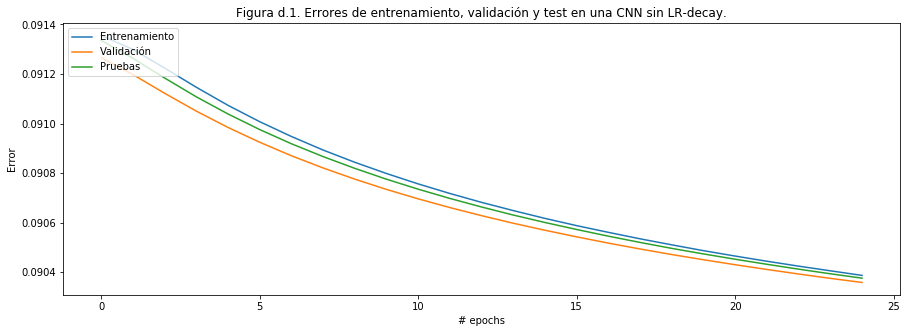

In [16]:
plotChart('Figura d.1. Errores de entrenamiento, validación y test en una CNN sin LR-decay.', history_d1.history['loss'], 'Entrenamiento',
          history_d1.history['val_loss'], 'Validación',ht_d1.test_error, 'Pruebas')

In [17]:
getData()
normalize()
model_d2 = modelC()
history_d2, ht_d2 = trainingD(model_d2, 25)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 27us/step - loss: 0.0908 - val_loss: 0.0907
Error Test (1): 0.0908
Epoch 2/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 25us/step - loss: 0.0908 - val_loss: 0.0907
Error Test (2): 0.0908
Epoch 3/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 0.0908 - val_loss: 0.0907
Error Test (3): 0.0907
Epoch 4/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 0.0907 - val_loss: 0.0906
Error Test (4): 0.0907
Epoch 5/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 25us/step - loss: 0.0907 - val_loss: 0.0906
Error Test (5): 0.0907
Epoch 6/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 25us/step - loss: 0.0907 - val_loss: 0.0906
Error Test (6): 0.0907
Epoch 7/25
Tasa de ap

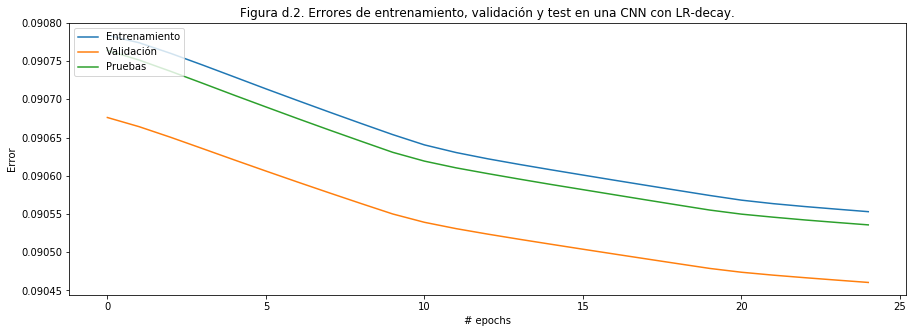

In [18]:
plotChart('Figura d.2. Errores de entrenamiento, validación y test en una CNN con LR-decay.', history_d2.history['loss'], 'Entrenamiento',
          history_d2.history['val_loss'], 'Validación',ht_d2.test_error, 'Pruebas')

> Tal como se muestra en los gráficos anteriores, el uso de un *decay* progresivo del *learning rate* permite una mejor y mas rapida convergencia, sin embargo, el efecto no es completamente apreciado dado la baja cantidad de epochs. 

##### Pregunta E.

> Red Convolucional con RMSProp.

In [9]:
def trainingE(model, epochs=25):
    global yt, xval, yval, xtr, ytr, xt, ht

    def step_decay(epoch):
        initial_lrate = 0.001
        lrate = initial_lrate * math.pow(0.5, math.floor(epoch / 10))
        lrate = max(lrate, 0.00001)
        print("Tasa de aprendizaje: " + str(lrate))
        return lrate

    class Histories(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.test_error = []

        def on_epoch_end(self, epoch, logs={}):
            predict = self.model.predict(xt)
            error = log_loss(yt, predict) #error de testing
            print("Error Test (" + str(epoch + 1) + "): " + str(round(error, 4)))
            self.test_error.append(error)
            return


    opt = RMSprop(lr=0.001)
    lrate = LearningRateScheduler(step_decay)
    ht = Histories()
    model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])
    history = model.fit(
        xtr,
        ytr,
        batch_size=5000,
        epochs=epochs,
        validation_data=(xval, yval),
        shuffle=True,
        callbacks=[lrate, ht])
    return history, ht

In [20]:
getData()
normalize()
model_e = modelC()
history_e, ht_e = trainingE(model_e)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 29us/step - loss: 2.2957 - acc: 0.1370 - val_loss: 2.2043 - val_acc: 0.2264
Error Test (1): 2.2026
Epoch 2/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 25us/step - loss: 2.1971 - acc: 0.2227 - val_loss: 2.2364 - val_acc: 0.1544
Error Test (2): 2.237
Epoch 3/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 25us/step - loss: 2.1149 - acc: 0.2498 - val_loss: 2.2800 - val_acc: 0.1970
Error Test (3): 2.2861
Epoch 4/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 2.0545 - acc: 0.2752 - val_loss: 2.1301 - val_acc: 0.2198
Error Test (4): 2.1257
Epoch 5/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 25us/step - loss: 1.9815 - acc: 0.2899 - val_loss: 1.9972 - val_acc: 0.2934
Error Test (5): 1.994
Epoch 6/25
Tasa de

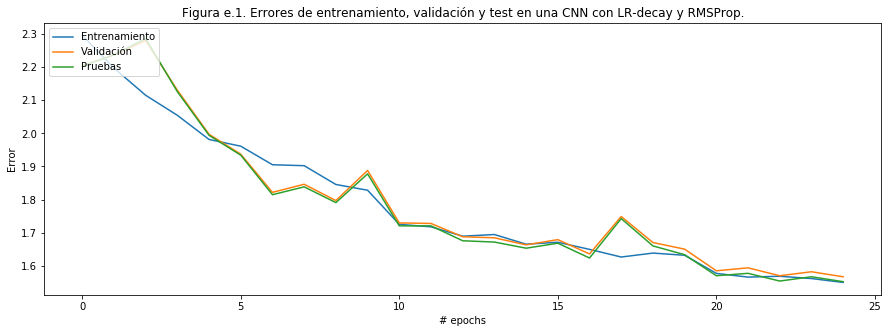

In [21]:
plotChart('Figura e.1. Errores de entrenamiento, validación y test en una CNN con LR-decay y RMSProp.', history_e.history['loss'], 'Entrenamiento',
          history_e.history['val_loss'], 'Validación',ht_e.test_error, 'Pruebas')

> Para el ejercicio anterior (gráfica *e.1*) se utilizo, además del optimizador **RMSProp**, la función de perdida **Cross Entropy**, con ello se logro una buena convergencia del modelo.

##### Pregunta F.

> A continuación se evaluan redes de distinto tamaño.

> La primera red a entrenar será una profunda del tipo CxPxCxPxCxPxFxF.

In [22]:
def modelF1(nc):
    model = Sequential()
    #C
    model.add(Conv2D(64, (nc, nc), padding='same', input_shape=xtr.shape[1:]))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #C
    model.add(Conv2D(64, (nc, nc), padding='same'))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #C
    model.add(Conv2D(64, (nc, nc), padding='same'))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #F
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    #F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

> El siguiente ciclo, generará experimentos con filtros de distinto tamaño: $\{2x2,4x4,6x6,8x8,10x10\}$ para la red profunda definida en *modelF1()*.

In [23]:
def getTrainingsF1():
    labels=[]
    hts=[]
    for i in range(5):
        nc=2*(i+1)
        str_filter=str(nc)+"x"+str(nc)
        print("Tamaño del Filtro="+str_filter)
        getData()
        normalize()
        model_f1 = modelF1(nc)
        history, ht=trainingE(model_f1,20)
        labels.append(str_filter)
        hts.append(ht)
    return labels, hts

In [24]:
labels_f1, hts_f1 = getTrainingsF1()

Tamaño del Filtro=2x2
Train on 45000 samples, validate on 5000 samples
Epoch 1/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 35us/step - loss: 2.2866 - acc: 0.1411 - val_loss: 2.1832 - val_acc: 0.2126
Error Test (1): 2.1853
Epoch 2/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 23us/step - loss: 2.1618 - acc: 0.2086 - val_loss: 2.1038 - val_acc: 0.2366
Error Test (2): 2.1017
Epoch 3/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 23us/step - loss: 2.0813 - acc: 0.2648 - val_loss: 1.9620 - val_acc: 0.3218
Error Test (3): 1.955
Epoch 4/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 22us/step - loss: 1.9881 - acc: 0.3028 - val_loss: 2.1377 - val_acc: 0.2304
Error Test (4): 2.135
Epoch 5/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 22us/step - loss: 1.9551 - acc: 0.3116 - val_loss: 1.8278 - val_acc: 0.3608
Error Test (5): 1.8

45000/45000 [==============================] - 3s 76us/step - loss: 2.1509 - acc: 0.2114 - val_loss: 2.0204 - val_acc: 0.2548
Error Test (6): 2.0147
Epoch 7/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 3s 76us/step - loss: 2.0714 - acc: 0.2491 - val_loss: 1.9989 - val_acc: 0.2772
Error Test (7): 1.9909
Epoch 8/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 3s 76us/step - loss: 2.0523 - acc: 0.2503 - val_loss: 2.4734 - val_acc: 0.1210
Error Test (8): 2.4797
Epoch 9/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 3s 76us/step - loss: 2.1045 - acc: 0.2328 - val_loss: 1.9608 - val_acc: 0.2846
Error Test (9): 1.9535
Epoch 10/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 3s 76us/step - loss: 1.9446 - acc: 0.2910 - val_loss: 1.9316 - val_acc: 0.3006
Error Test (10): 1.9161
Epoch 11/20
Tasa de aprendizaje: 0.0005
45000/45000 [==============================] - 3s 76us/step -

In [25]:
def plotMultipleF1(hts, labels, title ):
    plt.figure(figsize=(15,5))
    plt.title(title)
    for i in range(5):
        plt.plot(hts[i].test_error, label='Filtro '+labels[i])
    plt.legend(loc='upper left')
    plt.ylabel('Error')
    plt.xlabel('# epochs')
    plt.show()

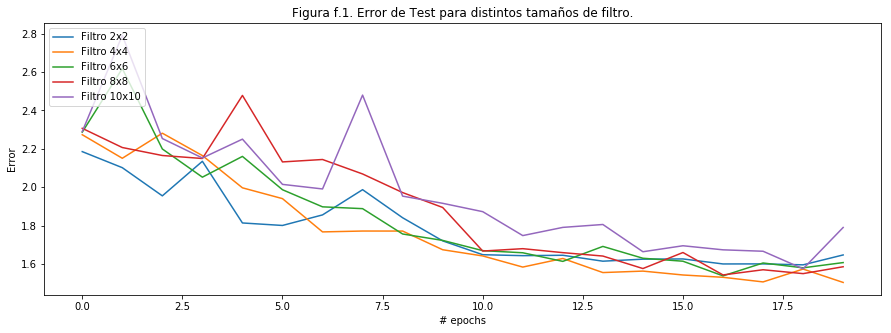

In [26]:
plotMultipleF1(hts_f1, labels_f1, 'Figura f.1. Error de Test para distintos tamaños de filtro.')

> Como es posible apreciar en la figura **f.1**, no detectamos mayor relación en la elección del tamaño del filtro y errores en el test, para la configuración que hemos elegido, sin embargo, se noto un mejor desempeño en el filtro de tamaño menor tamaño vs los de mayor tamaño.

> La segunda red a entrenar será una no profunda del tipo CxPxFxF.

In [27]:
def modelF2(nc):
    model = Sequential()
    #C
    model.add(Conv2D(64, (nc, nc), padding='same', input_shape=xtr.shape[1:]))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #F
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    #F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [28]:
def getTrainingsF2():
    labels=[]
    hts=[]
    for i in range(5):
        nc=2*(i+1)
        str_filter=str(nc)+"x"+str(nc)
        print("Tamaño del Filtro="+str_filter)
        getData()
        normalize()
        model_f2 = modelF2(nc)
        history, ht=trainingE(model_f2,20)
        labels.append(str_filter)
        hts.append(ht)
    return labels, hts

In [29]:
labels_f2, hts_f2 = getTrainingsF2()

Tamaño del Filtro=2x2
Train on 45000 samples, validate on 5000 samples
Epoch 1/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 26us/step - loss: 2.5638 - acc: 0.1812 - val_loss: 2.2255 - val_acc: 0.1896
Error Test (1): 2.2212
Epoch 2/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 20us/step - loss: 2.0906 - acc: 0.2637 - val_loss: 1.9668 - val_acc: 0.3026
Error Test (2): 1.9557
Epoch 3/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 20us/step - loss: 1.9965 - acc: 0.3134 - val_loss: 1.8840 - val_acc: 0.3358
Error Test (3): 1.869
Epoch 4/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 20us/step - loss: 1.9195 - acc: 0.3332 - val_loss: 1.8535 - val_acc: 0.3822
Error Test (4): 1.8423
Epoch 5/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 20us/step - loss: 1.8444 - acc: 0.3613 - val_loss: 1.9353 - val_acc: 0.3296
Error Test (5): 1.

45000/45000 [==============================] - 2s 43us/step - loss: 1.9933 - acc: 0.2986 - val_loss: 2.1241 - val_acc: 0.1950
Error Test (6): 2.1177
Epoch 7/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 43us/step - loss: 2.0346 - acc: 0.2724 - val_loss: 2.3322 - val_acc: 0.2126
Error Test (7): 2.3421
Epoch 8/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 43us/step - loss: 2.0229 - acc: 0.2880 - val_loss: 1.9187 - val_acc: 0.2932
Error Test (8): 1.9108
Epoch 9/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 43us/step - loss: 1.8130 - acc: 0.3563 - val_loss: 2.1296 - val_acc: 0.2694
Error Test (9): 2.1225
Epoch 10/20
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 43us/step - loss: 1.8792 - acc: 0.3307 - val_loss: 1.7659 - val_acc: 0.3678
Error Test (10): 1.7588
Epoch 11/20
Tasa de aprendizaje: 0.0005
45000/45000 [==============================] - 2s 43us/step -

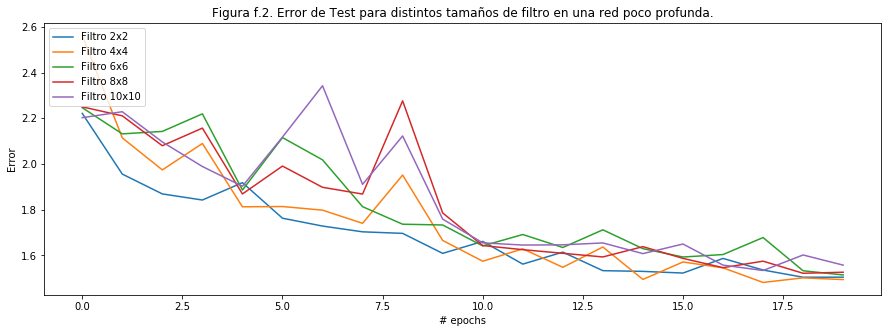

In [30]:
plotMultipleF1(hts_f2, labels_f2, 'Figura f.2. Error de Test para distintos tamaños de filtro en una red poco profunda.')

> Tal como se puede apreciar en la figura **f.2**, en este caso tampoco es notoria la diferencia para distintos tamaños de filtro. Sin embargo seguimos encontrando una mejor respuesta en tamaños de filtros menores.

##### Pregunta G.

> En el presente ejercicio se entrenarán dos redes de distinta arquitectura, una **CxPxCxPxFxF**, y otra **CxCxPxCxCxPxFxF**.

> Red CNN con estructura **CxPxCxPxFxF**:

In [10]:
def modelG1():
    model = Sequential()
    #C
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=xtr.shape[1:]))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #C
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #F
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    #F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [32]:
getData()
normalize()
model_g1 = modelG1()
history_g1, ht_g1 = trainingE(model_g1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 40us/step - loss: 2.4273 - acc: 0.1575 - val_loss: 2.3241 - val_acc: 0.1550
Error Test (1): 2.3304
Epoch 2/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 25us/step - loss: 2.1945 - acc: 0.2187 - val_loss: 2.0369 - val_acc: 0.2808
Error Test (2): 2.031
Epoch 3/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 2.0726 - acc: 0.2617 - val_loss: 2.1241 - val_acc: 0.2438
Error Test (3): 2.1203
Epoch 4/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 2.0119 - acc: 0.3018 - val_loss: 1.8736 - val_acc: 0.3374
Error Test (4): 1.8571
Epoch 5/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 24us/step - loss: 1.9265 - acc: 0.3262 - val_loss: 1.8993 - val_acc: 0.3306
Error Test (5): 1.8888
Epoch 6/25
Tasa d

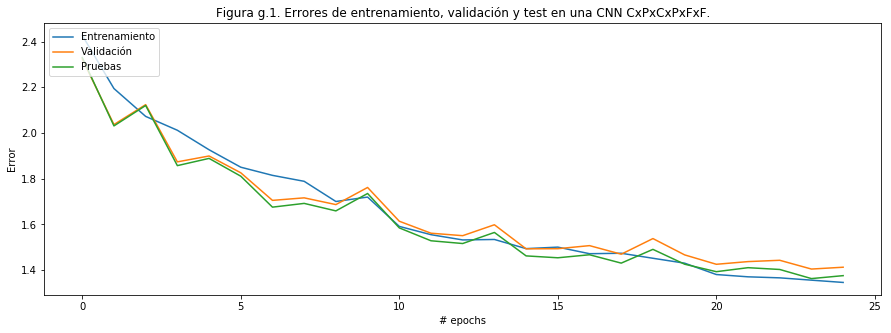

In [33]:
plotChart('Figura g.1. Errores de entrenamiento, validación y test en una CNN CxPxCxPxFxF.', history_g1.history['loss'], 'Entrenamiento',
          history_g1.history['val_loss'], 'Validación',ht_g1.test_error, 'Pruebas')

> Red CNN con estructura **CxCxPxCxCxPxFxF**.

In [35]:
def modelG2():
    model = Sequential()
    #C
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=xtr.shape[1:]))
    model.add(Activation('relu'))
    #C
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #C
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #C
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #F
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    #F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [35]:
getData()
normalize()
model_g2 = modelG2()
history_g2, ht_g2 = trainingE(model_g2)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 54us/step - loss: 2.3755 - acc: 0.1256 - val_loss: 2.2719 - val_acc: 0.1708
Error Test (1): 2.2722
Epoch 2/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 36us/step - loss: 2.3238 - acc: 0.1577 - val_loss: 2.7100 - val_acc: 0.1222
Error Test (2): 2.7092
Epoch 3/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 36us/step - loss: 2.3204 - acc: 0.1728 - val_loss: 2.2458 - val_acc: 0.2010
Error Test (3): 2.2428
Epoch 4/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 36us/step - loss: 2.2205 - acc: 0.2101 - val_loss: 2.0499 - val_acc: 0.2648
Error Test (4): 2.0427
Epoch 5/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 36us/step - loss: 2.2400 - acc: 0.2188 - val_loss: 1.9743 - val_acc: 0.2964
Error Test (5): 1.9683
Epoch 6/25
Tasa 

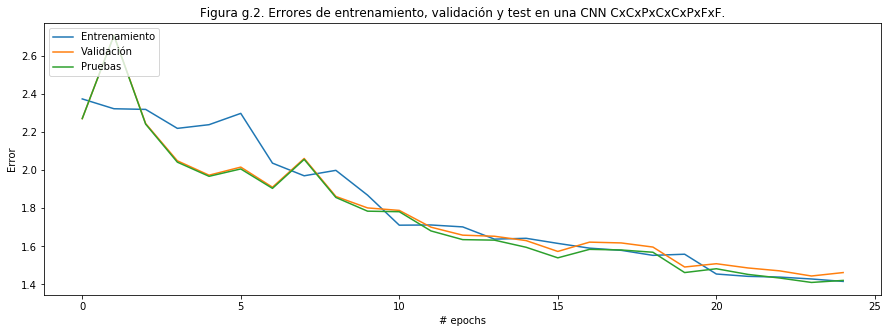

In [36]:
plotChart('Figura g.2. Errores de entrenamiento, validación y test en una CNN CxCxPxCxCxPxFxF.', history_g2.history['loss'], 'Entrenamiento',
          history_g2.history['val_loss'], 'Validación',ht_g2.test_error, 'Pruebas')

> Como se puede apreciar en las figuras **g.1** y **g.2**, la red tiene un comportamiento mas estable cuando se entrena con *polling* intermedio, así mismo, el nivel de precisión de la red, converge mas lentamente. 

##### Pregunta H.

> En el presente ejercicio reemplazaremos una capa de pooling por una capa convolucional con $strides=2x2$, para poder verificar la diferencia de la estructura haremos un modelo sin este cambio (**modelH1**), versus con el que tiene el cambio (**modelH2**).

In [37]:
def modelH1():
    model = Sequential()
    #C
    model.add(Conv2D(128, (3, 3), padding='same', input_shape=xtr.shape[1:]))
    model.add(Activation('relu'))
    #C
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #F
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    #F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [38]:
def modelH2():
    model = Sequential()
    #C
    model.add(Conv2D(128, (3, 3), padding='same', input_shape=xtr.shape[1:]))
    model.add(Activation('relu'))
    #C
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #C w/ Sride
    model.add(Conv2D(64, (3, 3), strides=(2,2),padding='same'))
    model.add(Activation('relu'))
    #F
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    #F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [39]:
print("Modelo sin Stride:")
model_h1 = modelH1()
model_h1.summary()
print("Modelo con Stride:")
model_h2 = modelH2()
model_h2.summary()

Modelo sin Stride:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 3, 32, 128)        36992     
_________________________________________________________________
activation_67 (Activation)   (None, 3, 32, 128)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 3, 32, 128)        147584    
_________________________________________________________________
activation_68 (Activation)   (None, 3, 32, 128)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 3, 16, 64)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               15

> Tal como vimos en la pregunta **C**, a pesar que las capas de *pooling* no influyen en la cantidad de parametros a entrenar y  si lo hace la capa convolucional con *stride*, ésta lo hace disminuyendo la cantidad de parametros, logrando una reducción de mas del $25\%$ en la cantidad de parámetros a entrenar.

In [40]:
getData()
normalize()
model_g1 = modelH1()
history_h1, ht_h1 = trainingE(model_h1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 3s 59us/step - loss: 2.9015 - acc: 0.1357 - val_loss: 2.2776 - val_acc: 0.1474
Error Test (1): 2.2753
Epoch 2/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 37us/step - loss: 2.3085 - acc: 0.1852 - val_loss: 2.1653 - val_acc: 0.2662
Error Test (2): 2.1661
Epoch 3/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 38us/step - loss: 2.1480 - acc: 0.2343 - val_loss: 2.5323 - val_acc: 0.1520
Error Test (3): 2.5364
Epoch 4/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 37us/step - loss: 2.1474 - acc: 0.2419 - val_loss: 2.0515 - val_acc: 0.2618
Error Test (4): 2.0499
Epoch 5/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 37us/step - loss: 2.1424 - acc: 0.2652 - val_loss: 2.0182 - val_acc: 0.2680
Error Test (5): 2.0138
Epoch 6/25
Tasa 

In [41]:
getData()
normalize()
model_g2 = modelH2()
history_h2, ht_h2 = trainingE(model_h2)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 3s 58us/step - loss: 2.5374 - acc: 0.1260 - val_loss: 2.2727 - val_acc: 0.1302
Error Test (1): 2.2719
Epoch 2/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 42us/step - loss: 2.5546 - acc: 0.1673 - val_loss: 2.2573 - val_acc: 0.1040
Error Test (2): 2.2537
Epoch 3/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 43us/step - loss: 2.2002 - acc: 0.1992 - val_loss: 2.0965 - val_acc: 0.2422
Error Test (3): 2.0909
Epoch 4/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 43us/step - loss: 2.2325 - acc: 0.2398 - val_loss: 2.0961 - val_acc: 0.2720
Error Test (4): 2.0984
Epoch 5/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 2s 43us/step - loss: 2.0413 - acc: 0.2715 - val_loss: 1.8384 - val_acc: 0.3590
Error Test (5): 1.8306
Epoch 6/25
Tasa 

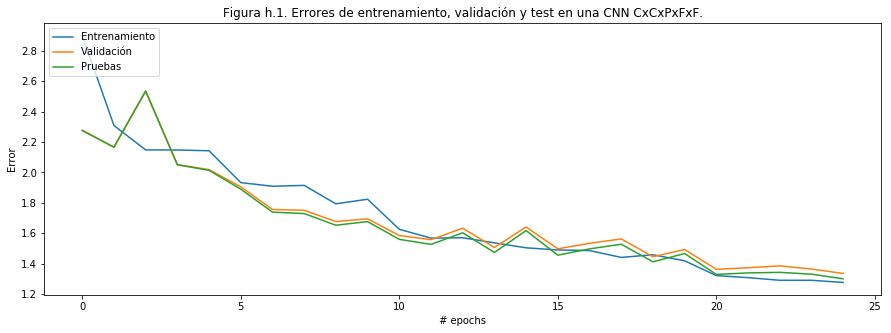

In [42]:
plotChart('Figura h.1. Errores de entrenamiento, validación y test en una CNN CxCxPxFxF.', history_h1.history['loss'], 'Entrenamiento',
              history_h1.history['val_loss'], 'Validación',ht_h1.test_error, 'Pruebas')

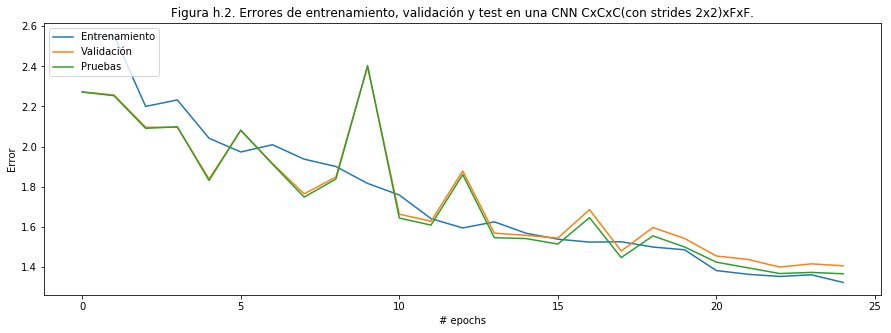

In [43]:
plotChart('Figura h.2. Errores de entrenamiento, validación y test en una CNN CxCxC(con strides 2x2)xFxF.', history_h2.history['loss'], 'Entrenamiento',
          history_h2.history['val_loss'], 'Validación',ht_h2.test_error, 'Pruebas')

> Como se puede apreciar en las figuras **h.1** y **h.2**, los cambios en la CNN se notan principalmente por un menor error y una mejor velocidad de convergencia.

##### Pregunta I.

> En el presente ejercicio haremos los siguientes cambios en la data previa: rotación a 90°, flip horizontal y shift vertical, entrenaremos y veremos el efecto de estos cambios en el comportamiento de la predicción.

In [10]:
def getXtrRotated():
    datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=90, # randomly rotate images (degrees, 0 to 180)
        width_shift_range=0, # randomly shift images horizontally (fraction of width)
        height_shift_range=0, # randomly shift images vertically (fraction of height)
        horizontal_flip=False, # randomly flip images
        vertical_flip=False) # randomly flip images
    return datagen

In [11]:
def getXtrHFlipped():
    datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=0, # randomly rotate images (degrees, 0 to 180)
        width_shift_range=0, # randomly shift images horizontally (fraction of width)
        height_shift_range=0, # randomly shift images vertically (fraction of height)
        horizontal_flip=True, # randomly flip images
        vertical_flip=False) # randomly flip images
    return datagen

In [12]:
def getXtrVShift():
    global xtr
    datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=0, # randomly rotate images (degrees, 0 to 180)
        width_shift_range=0, # randomly shift images horizontally (fraction of width)
        height_shift_range=0.5, # randomly shift images vertically (fraction of height)
        horizontal_flip=False, # randomly flip images
        vertical_flip=False) # randomly flip images  
    return datagen

In [13]:
def modelI():
    
    model = Sequential()
    #C
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=xtr.shape[1:]))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #C
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    #P
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    #F
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    #F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [16]:
def trainingI(model, datagen,epochs=25 ):
    global yt, xval, yval, xtr, ytr, xt, ht

    def step_decay(epoch):
        initial_lrate = 0.001
        lrate = initial_lrate * math.pow(0.5, math.floor(epoch / 10))
        lrate = max(lrate, 0.00001)
        print("Tasa de aprendizaje: " + str(lrate))
        return lrate

    class Histories(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.test_error = []

        def on_epoch_end(self, epoch, logs={}):
            predict = self.model.predict(xt)
            error = log_loss(yt, predict)  #error de testing
            print("Error Test (" + str(epoch + 1) + "): " +
                  str(round(error, 4)))
            self.test_error.append(error)
            return

    opt = RMSprop(lr=0.001)
    lrate = LearningRateScheduler(step_decay)
    ht = Histories()
    model.compile(
        optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    datagen.fit(xtr)

    history = model.fit_generator(
        datagen.flow(xtr, ytr, batch_size=5000),
        steps_per_epoch=xtr.shape[0] // 5000,
        epochs=epochs,
        validation_data=(xval, yval),
        callbacks=[lrate, ht])

    return history, ht

In [18]:
getData()
normalize()
datagen=getXtrRotated()
model_i1=modelI()
history_i1, ht_i1=trainingI(model_i1,datagen,20)

Epoch 1/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 20s 2s/step - loss: 2.3316 - acc: 0.1283 - val_loss: 2.2004 - val_acc: 0.2244
Error Test (1): 2.1998
Epoch 2/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 19s 2s/step - loss: 2.2396 - acc: 0.1658 - val_loss: 2.1873 - val_acc: 0.1704
Error Test (2): 2.1835
Epoch 3/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 20s 2s/step - loss: 2.1824 - acc: 0.1975 - val_loss: 2.0535 - val_acc: 0.2760
Error Test (3): 2.0466
Epoch 4/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 19s 2s/step - loss: 2.1446 - acc: 0.2186 - val_loss: 2.0342 - val_acc: 0.2774
Error Test (4): 2.0318
Epoch 5/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 19s 2s/step - loss: 2.1354 - acc: 0.2302 - val_loss: 2.0020 - val_acc: 0.3010
Error Test (5): 1.9869
Epoch 6/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 20s 2s/step - loss: 2.1022 - acc:

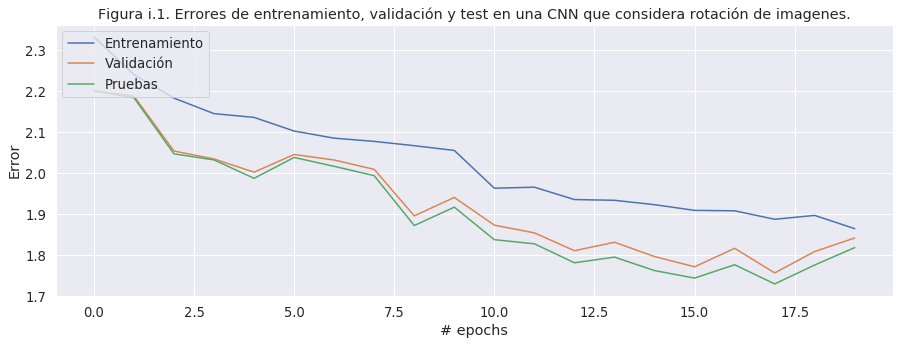

In [220]:
plotChart('Figura i.1. Errores de entrenamiento, validación y test en una CNN que considera rotación de imagenes.', history_i1.history['loss'], 'Entrenamiento',
          history_i1.history['val_loss'], 'Validación',ht_i1.test_error, 'Pruebas')

In [22]:
getData()
normalize()
datagen=getXtrHFlipped()
model_i2=modelI()
history_i2, ht_i2=trainingI(model_i2,datagen,20)

/home/rohermosilla/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras_preprocessing/image.py:1358: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (45000, 3, 32, 32) (32 channels).
  ' channels).')
/home/rohermosilla/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (45000, 3, 32, 32) (32 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 1s 88ms/step - loss: 2.3312 - acc: 0.1197 - val_loss: 2.2493 - val_acc: 0.1906
Error Test (1): 2.2506
Epoch 2/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 0s 55ms/step - loss: 2.3311 - acc: 0.1656 - val_loss: 2.1840 - val_acc: 0.2028
Error Test (2): 2.1834
Epoch 3/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 0s 54ms/step - loss: 2.1571 - acc: 0.2119 - val_loss: 2.1207 - val_acc: 0.2224
Error Test (3): 2.1147
Epoch 4/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 1s 56ms/step - loss: 2.1353 - acc: 0.2478 - val_loss: 2.1069 - val_acc: 0.2330
Error Test (4): 2.0908
Epoch 5/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 1s 57ms/step - loss: 2.0838 - acc: 0.2596 - val_loss: 2.1485 - val_acc: 0.2220
Error Test (5): 2.1379
Epoch 6/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 0s 55ms/step - loss: 2.0386 

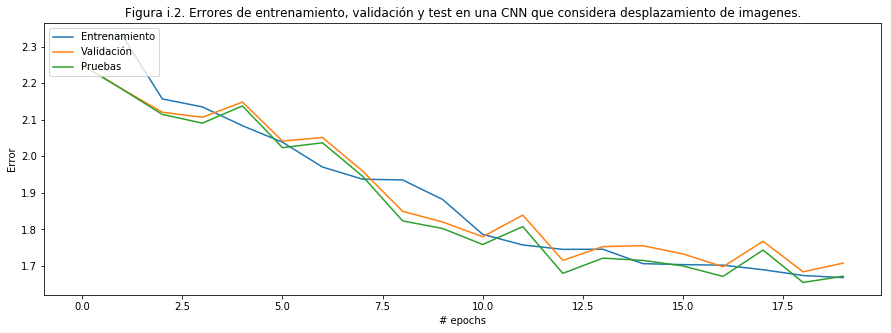

In [23]:
plotChart('Figura i.2. Errores de entrenamiento, validación y test en una CNN que considera desplazamiento de imagenes.', history_i2.history['loss'], 'Entrenamiento',
          history_i2.history['val_loss'], 'Validación',ht_i2.test_error, 'Pruebas')

In [24]:
getData()
normalize()
datagen=getXtrVShift()
model_i3=modelI()
history_i3, ht_i3=trainingI(model_i3,datagen,20)

/home/rohermosilla/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras_preprocessing/image.py:1358: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (45000, 3, 32, 32) (32 channels).
  ' channels).')
/home/rohermosilla/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/keras_preprocessing/image.py:1643: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (45000, 3, 32, 32) (32 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 20s 2s/step - loss: 2.3403 - acc: 0.1396 - val_loss: 2.2266 - val_acc: 0.1844
Error Test (1): 2.227
Epoch 2/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 19s 2s/step - loss: 2.2166 - acc: 0.1904 - val_loss: 2.1269 - val_acc: 0.2784
Error Test (2): 2.1215
Epoch 3/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 19s 2s/step - loss: 2.1309 - acc: 0.2468 - val_loss: 2.0031 - val_acc: 0.2980
Error Test (3): 1.9921
Epoch 4/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 19s 2s/step - loss: 2.0669 - acc: 0.2632 - val_loss: 1.9910 - val_acc: 0.3086
Error Test (4): 1.9813
Epoch 5/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 19s 2s/step - loss: 2.0001 - acc: 0.2959 - val_loss: 1.9769 - val_acc: 0.2972
Error Test (5): 1.9698
Epoch 6/20
Tasa de aprendizaje: 0.001
9/9 [==============================] - 19s 2s/step - loss: 1.9618 - acc: 

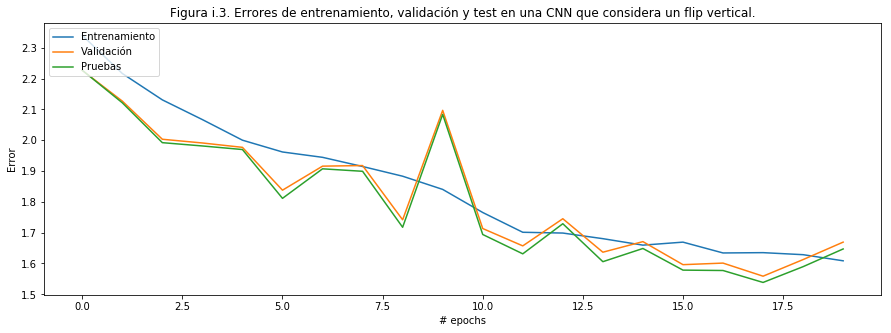

In [25]:
plotChart('Figura i.3. Errores de entrenamiento, validación y test en una CNN que considera un flip vertical.', history_i3.history['loss'], 'Entrenamiento',
          history_i3.history['val_loss'], 'Validación',ht_i3.test_error, 'Pruebas')

> Tal como se pudo comprobar en las figuras **i.1**, **i.2** y **1.3**, la red tuvo un peor comportamiento en el caso de la rotación de $90\%$ esto claramente porque se debia a imagenes (ciertas imagenes, ya que el generador solo aplica el efecto de manera aleatoria en las imagenes) con características peores para poder identificar en la red, en terminos de mala calidad, le siguio la red con un flip vertical, nuevamente, porque aqui se encontraban imagenes *distintas* al set de entrenamiento optimo, una imagen rotada o imagen reflejada en uno de los ejes, claramente genera una dificultad adicional a la predicción de la red.

##### Pregunta J.

> **J.1**. Las siguientes funciones procesarán el set de entrenamiento *CIFAR-10* y calcularán el *SIFT*, según el enunciado.

In [11]:
def pre_process(img):
    if np.max(img) <= 1:
        img*=255
    img = img.astype("uint8")
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray

In [12]:
def calculate_sift(cifar):
    sift_cifar = []
    for image in cifar:
      img_gray = pre_process(image)
      sift = cv2.xfeatures2d.SIFT_create()
      kp, desc = sift.detectAndCompute(img_gray, None)
      if type(desc) == type(None):
        desc = np.zeros((1,128))
      compress_desc = np.mean(desc,axis=0) #compress all keypoints
      sift_cifar.append(compress_desc)
    return np.asarray(sift_cifar)
getData()
cs_train = calculate_sift(X_train)
cs_val = calculate_sift(X_val)
cs_test = calculate_sift(X_test)

> **J.2**. Visualizaremos y entrenaremos la red con la nueva información.

In [32]:
getData()
normalize()
sample_image = X_train[1]
gray_sample_image = pre_process(sample_image)
sift = cv2.xfeatures2d.SIFT_create()
kp, desc = sift.detectAndCompute(gray_sample_image, None)
"""draw and plot"""
img=cv2.drawKeypoints(gray_sample_image,kp,gray_sample_image)

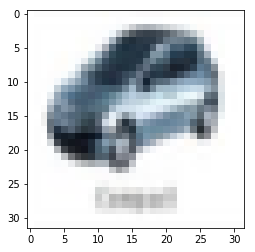

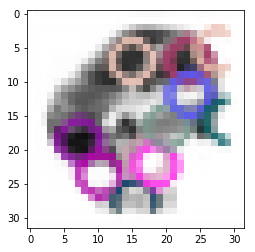

In [33]:
plt.imshow(sample_image)
plt.show()
plt.imshow(cv2.drawKeypoints(gray_sample_image, kp, gray_sample_image.copy()))
plt.show()

> Para efectos de entrenar los valores *CIFT* usaremos en modelo con estructura **FxFxF**.

In [90]:
def modelJ():
    model = Sequential()
    #F
    model.add(Dense(512))
    model.add(Activation('relu'))
    #F
    model.add(Dense(512))
    model.add(Activation('relu'))
    #F
    model.add(Dense(10))
    model.add(Activation('softmax'))
    return model

In [91]:
model_j=modelJ();

> Normalizaremos los valores provenientes de *CIFT*.

In [92]:
scaler = StandardScaler().fit(cs_train)
xtr=scaler.transform(cs_train)
xt=scaler.transform(cs_test)
xval=scaler.transform(cs_val)

> Entrenaremos la red densa del tipo FxFxF, con 250 *epochs*.

In [93]:
history_j, ht_j = trainingE(model_j, epochs=250)

Train on 45000 samples, validate on 5000 samples
Epoch 1/250
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 0s 10us/step - loss: 2.2427 - acc: 0.2056 - val_loss: 2.0520 - val_acc: 0.2612
Error Test (1): 2.0453
Epoch 2/250
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 0s 2us/step - loss: 2.0314 - acc: 0.2664 - val_loss: 2.0224 - val_acc: 0.2682
Error Test (2): 2.0119
Epoch 3/250
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 0s 2us/step - loss: 1.9859 - acc: 0.2898 - val_loss: 1.9991 - val_acc: 0.2876
Error Test (3): 1.9872
Epoch 4/250
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 0s 2us/step - loss: 1.9517 - acc: 0.3008 - val_loss: 2.0147 - val_acc: 0.2706
Error Test (4): 2.0069
Epoch 5/250
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 0s 2us/step - loss: 1.9200 - acc: 0.3175 - val_loss: 1.9996 - val_acc: 0.2840
Error Test (5): 1.9936
Epoch 6/250
Tas

Error Test (43): 1.9066
Epoch 44/250
Tasa de aprendizaje: 6.25e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5804 - acc: 0.4581 - val_loss: 1.9118 - val_acc: 0.3254
Error Test (44): 1.9072
Epoch 45/250
Tasa de aprendizaje: 6.25e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5787 - acc: 0.4595 - val_loss: 1.9124 - val_acc: 0.3264
Error Test (45): 1.9068
Epoch 46/250
Tasa de aprendizaje: 6.25e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5768 - acc: 0.4592 - val_loss: 1.9115 - val_acc: 0.3246
Error Test (46): 1.9074
Epoch 47/250
Tasa de aprendizaje: 6.25e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5752 - acc: 0.4603 - val_loss: 1.9132 - val_acc: 0.3264
Error Test (47): 1.9077
Epoch 48/250
Tasa de aprendizaje: 6.25e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5734 - acc: 0.4614 - val_loss: 1.9132 - val_acc: 0.3244
Error Test (48): 1.9084
Epoch 49/250
Tas

Error Test (86): 1.9115
Epoch 87/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5481 - acc: 0.4713 - val_loss: 1.9169 - val_acc: 0.3234
Error Test (87): 1.9116
Epoch 88/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5478 - acc: 0.4719 - val_loss: 1.9169 - val_acc: 0.3232
Error Test (88): 1.9116
Epoch 89/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5475 - acc: 0.4715 - val_loss: 1.9170 - val_acc: 0.3230
Error Test (89): 1.9117
Epoch 90/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5473 - acc: 0.4718 - val_loss: 1.9171 - val_acc: 0.3232
Error Test (90): 1.9117
Epoch 91/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5470 - acc: 0.4722 - val_loss: 1.9171 - val_acc: 0.3234
Error Test (91): 1.9117
Epoch 92/250
Tasa de aprendizaj

45000/45000 [==============================] - 0s 2us/step - loss: 1.5359 - acc: 0.4769 - val_loss: 1.9194 - val_acc: 0.3236
Error Test (130): 1.9139
Epoch 131/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5356 - acc: 0.4765 - val_loss: 1.9194 - val_acc: 0.3230
Error Test (131): 1.914
Epoch 132/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5353 - acc: 0.4773 - val_loss: 1.9195 - val_acc: 0.3226
Error Test (132): 1.914
Epoch 133/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5350 - acc: 0.4767 - val_loss: 1.9195 - val_acc: 0.3238
Error Test (133): 1.9141
Epoch 134/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5348 - acc: 0.4768 - val_loss: 1.9196 - val_acc: 0.3244
Error Test (134): 1.9142
Epoch 135/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 

45000/45000 [==============================] - 0s 2us/step - loss: 1.5237 - acc: 0.4824 - val_loss: 1.9220 - val_acc: 0.3256
Error Test (173): 1.9165
Epoch 174/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5234 - acc: 0.4826 - val_loss: 1.9221 - val_acc: 0.3248
Error Test (174): 1.9166
Epoch 175/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5232 - acc: 0.4823 - val_loss: 1.9221 - val_acc: 0.3256
Error Test (175): 1.9167
Epoch 176/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5229 - acc: 0.4828 - val_loss: 1.9223 - val_acc: 0.3250
Error Test (176): 1.9168
Epoch 177/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5226 - acc: 0.4830 - val_loss: 1.9223 - val_acc: 0.3246
Error Test (177): 1.9168
Epoch 178/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] 

45000/45000 [==============================] - 0s 3us/step - loss: 1.5117 - acc: 0.4873 - val_loss: 1.9248 - val_acc: 0.3246
Error Test (216): 1.9193
Epoch 217/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5114 - acc: 0.4872 - val_loss: 1.9248 - val_acc: 0.3244
Error Test (217): 1.9193
Epoch 218/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5111 - acc: 0.4873 - val_loss: 1.9249 - val_acc: 0.3248
Error Test (218): 1.9194
Epoch 219/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5108 - acc: 0.4876 - val_loss: 1.9250 - val_acc: 0.3250
Error Test (219): 1.9194
Epoch 220/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] - 0s 2us/step - loss: 1.5105 - acc: 0.4881 - val_loss: 1.9250 - val_acc: 0.3248
Error Test (220): 1.9195
Epoch 221/250
Tasa de aprendizaje: 1e-05
45000/45000 [==============================] 

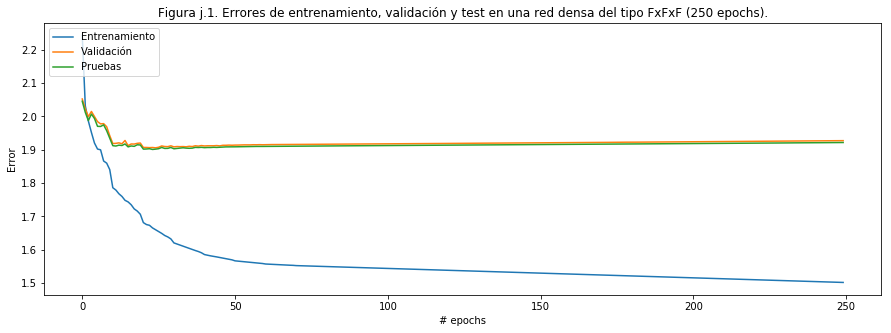

In [94]:
plotChart('Figura j.1. Errores de entrenamiento, validación y test en una red densa del tipo FxFxF (250 epochs).', history_j.history['loss'], 'Entrenamiento',
          history_j.history['val_loss'], 'Validación',ht_j.test_error, 'Pruebas')

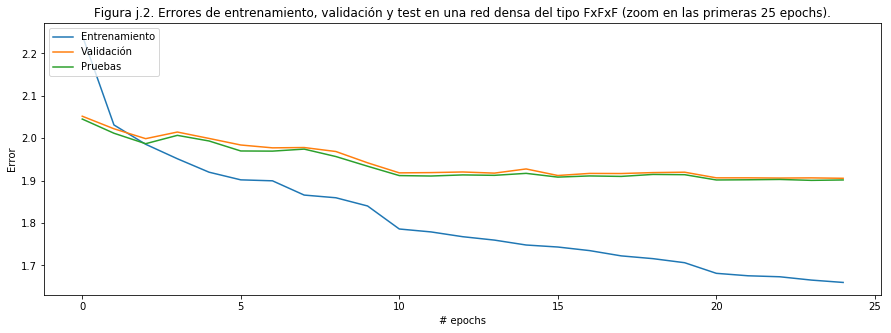

In [95]:
plotChart('Figura j.2. Errores de entrenamiento, validación y test en una red densa del tipo FxFxF (zoom en las primeras 25 epochs).', history_j.history['loss'][:25], 'Entrenamiento',
          history_j.history['val_loss'][:25], 'Validación',ht_j.test_error[:25], 'Pruebas')

> Tal como se visualiza en las graficas **j.1** y **j.2**, este tipo de entrenamiento ofrece una mayor velocidad de entrenamiento, sin embargo no logra converger.

##### Pregunta K.

> Para efectos de resolver este punto se ha elegido el modelo utilizado en la pregunta G (*modelG1*), dado su buen desempeño. Este modelo se entrenará con la configuración de entrenamiento vista en la pregunta E (*trainingE*).

In [16]:
getData()
normalize()
model_k = modelG1()
history_k, ht_k = trainingE(model_k)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 3s 73us/step - loss: 2.4547 - acc: 0.1449 - val_loss: 2.2581 - val_acc: 0.1300
Error Test (1): 2.2598
Epoch 2/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 21us/step - loss: 2.2380 - acc: 0.1999 - val_loss: 2.1524 - val_acc: 0.2512
Error Test (2): 2.1502
Epoch 3/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 21us/step - loss: 2.1379 - acc: 0.2520 - val_loss: 2.0749 - val_acc: 0.2544
Error Test (3): 2.0709
Epoch 4/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 21us/step - loss: 2.0726 - acc: 0.2860 - val_loss: 1.9566 - val_acc: 0.2924
Error Test (4): 1.9416
Epoch 5/25
Tasa de aprendizaje: 0.001
45000/45000 [==============================] - 1s 21us/step - loss: 1.9766 - acc: 0.3045 - val_loss: 1.9211 - val_acc: 0.3356
Error Test (5): 1.9131
Epoch 6/25
Tasa 

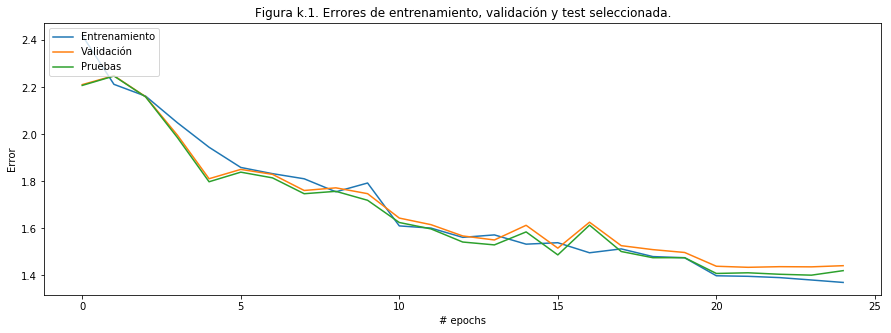

In [19]:
plotChart('Figura k.1. Errores de entrenamiento, validación y test seleccionada.', history_k.history['loss'], 'Entrenamiento',
          history_k.history['val_loss'], 'Validación',ht_k.test_error, 'Pruebas')

> Para poder identificar claramente los pares que mas tiende a confundir la red, se utilizo un método llamado *matriz de confusión*, que como se verá permite ver la predicción de cada caso vs. su valor real.

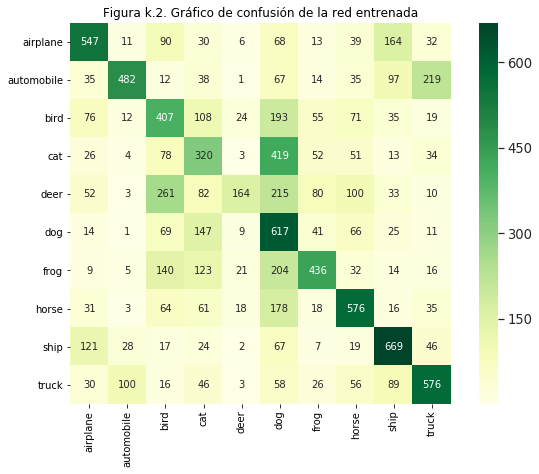

In [23]:
predict = model_k.predict(xt)
error = log_loss(yt, predict)  #error de testing
Y_pred = model_k.predict(xt, verbose=2)
y_pred = np.argmax(Y_pred, axis=-1)
cm = confusion_matrix(np.argmax(yt,axis=-1),y_pred)
df_cm = pd.DataFrame(cm, range(10),
                  label_names)
for i in range(10):
    df_cm.rename(index={i:label_names[i]}, inplace=True)
plt.figure(figsize = (10,7))
plt.title('Figura k.2. Gráfico de confusión de la red entrenada')
plt.ylabel('Valor de Prueba')
plt.xlabel('Predicción')
sn.set(font_scale=1.2)#for label size
sn.heatmap(df_cm, annot=True,square=True,annot_kws={"size": 10},cmap='YlGn', fmt='g')# font size
plt.show()

> Tal como es posible apreciar en la figura **k.2**, los pares que mas tiende a confundir la red son (con mas de 100 predicciones):

> |Predicción|Real   |#Confusión|
> |:---|:-------|---:|
> |Camión (truck)|Auto (automotive)|219|
> |Barco (ship)|Avión (airplane)|209|
> |Rana (frog)|Gato (gato)|200|
> |Auto (automobile)|Camión (truck)|194|
> |Rana (frog)|Ciervo (deer)|181|
> |Rana (frog)|Pajaro (bird)|167|
> |Rana (frog)|Perro (dog)|164|
> |Gato (cat)|Perro (dog)|150|
> |Ciervo (deer)|Pajaro (bird)|136|
> |Perro (dog)|Gato (cat)|127|
> |Caballo (horse)|Perro (dog)|114|
> |Caballo (horse)|Ciervo (deer)|106|
> |Camión (truck)|Gato (cat)|106|
> |Pájaro (bird)|Ciervo (deer)|104|
> |Avión (airplane)|Pájaro (bird)|101|
> |Camión (truck)|Caballo (horse)|101|

> Es claro ver en la lista anterior, que aquellos elementos que mas producen confusión, son los que tienen una apariencia similar, o que comparten colores similares, algo muy parecido a lo que sucede si una persona tiene problemas de visión, y trata de adivinar que imagen esta viendo.

##### Pregunta L.

> A continuación se muestran las primeras 15 figuras caracterizadas por *SIFT*.

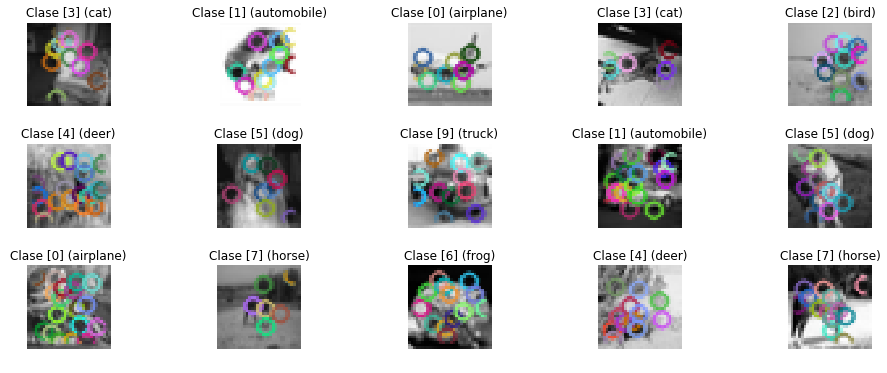

In [17]:
fig = plt.figure(figsize=(16,6))
for i in range(0, 3*5):
    fig.add_subplot(3,5,i+1)
    im = X_train[i].reshape(32,32,3)
    gray_image = pre_process(im)
    plt.imshow(im)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_image, None)
    """draw and plot"""
    plt.imshow(cv2.drawKeypoints(gray_image, kp, gray_image.copy()))
    plt.title("Clase "+str(y_train[i])+" ("+label_names[int(y_train[i])]+")")
    plt.axis('off')
    plt.subplots_adjust(hspace=0.45, wspace=0.45)
plt.show()

> A continuación se muestran las mismas figuras tal cual se encuentran en el set de entrenamiento.

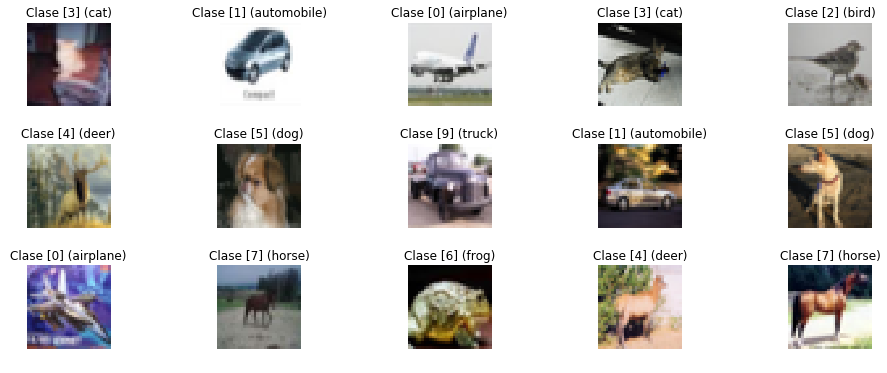

In [18]:
fig = plt.figure(figsize=(16,6))
for i in range(0, 3*5):
    fig.add_subplot(3,5,i+1)
    im = X_train[i].reshape(32,32,3)
    plt.imshow(im)
    plt.title("Clase "+str(y_train[i])+" ("+label_names[int(y_train[i])]+")")
    plt.axis('off')
    plt.subplots_adjust(hspace=0.45, wspace=0.45)
plt.show()

> Considerando la CNN utilizada en la pregunta anterior (*ModelG1* y *TrainingE*), podemos revisar el resultado de la primera y ultima capa convolucional.

In [19]:
model_k.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 32, 64)         18496     
_________________________________________________________________
activation_1 (Activation)    (None, 3, 32, 64)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 16, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 16, 128)        36992     
_________________________________________________________________
activation_2 (Activation)    (None, 3, 16, 128)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
__________

In [20]:
layers_output=[]
for i in range(6):
    get_layer_output = K.function([model_k.layers[0].input],
                                  [model_k.layers[i].output])
    layers_output.append(get_layer_output([xtr])[0])

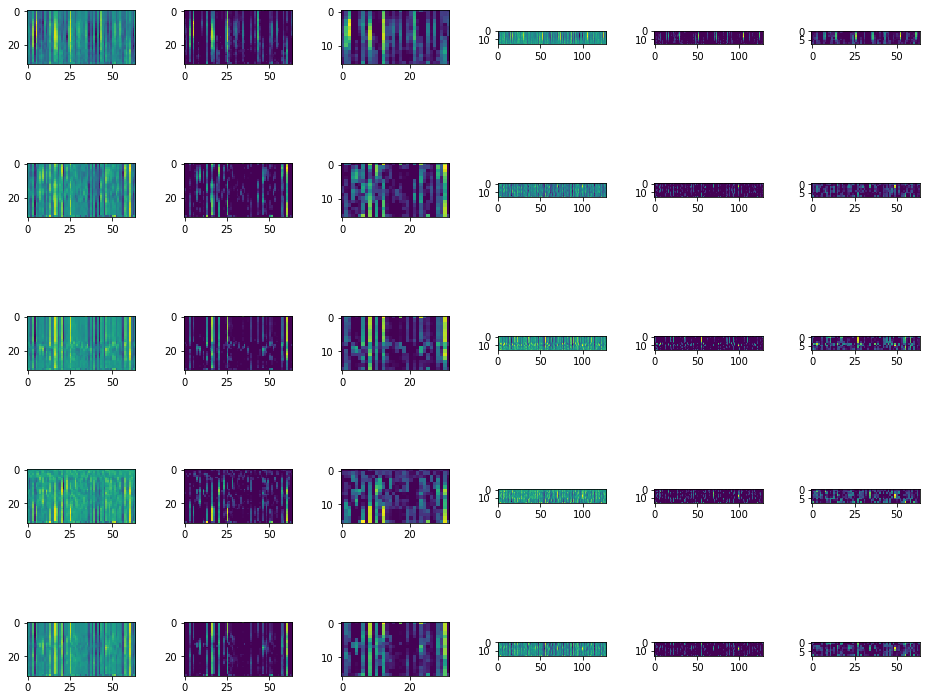

In [26]:
fig = plt.figure(figsize=(16,16))
cont=0
for j in range(5):
    for i in range(6):
        cont=cont+1
        fig.add_subplot(6,6,cont)
        lo=layers_output[i]
        plt.imshow(lo[j][1])
    plt.subplots_adjust(hspace=0.45, wspace=0.45)
plt.show()
    

> Tal como se muestra en el set de figuras anteriores, es posible ver, que al igual que con los descriptores *SIFT*, las imagenes se van convirtiendo en las distintas capas en un conjunto de características.